## Download dataset

In [22]:
from pathlib import Path 

p = Path().resolve()

print(p.parent / "data")

/workspaces/sport-image-classifier/data


In [15]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("gpiosenka/sports-classification")

print("Path to dataset files:", dataset_path)

Path to dataset files: /home/codespace/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9


In [23]:
from pathlib import Path
import shutil

eda_folder = Path().resolve()
data_folder = eda_folder.parent / "data"

source = Path(dataset_path)
destination = data_folder

# Move all items (files and directories)
for item in source.iterdir():
    shutil.move(str(item), str(destination / item.name))

## Exploratory Data Analysis

In [24]:
import numpy as np
import torch

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [25]:
from torchvision import models
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models

from pathlib import Path
from collections import Counter

from PIL import Image
import numpy as np

In [27]:
data_folder / "train"

PosixPath('/workspaces/sport-image-classifier/data/train')

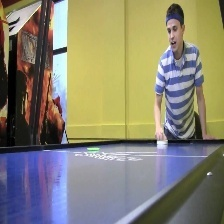

In [28]:
# Original Image
img = Image.open(data_folder / "train" / "air hockey" / "001.jpg")
img

In [29]:
# Dataset structure and size

data_dir =   data_folder / "train"
sport_types = [d.name for d in data_dir.glob('*') if d.is_dir()]

print(f'Number of sport types: {len(sport_types)}')

sport_type_counts = {}

for sport_type in sport_types:
    sport_type_dir = data_dir / sport_type
    num_images = len(list(sport_type_dir.glob('*.jpg')))
    print(f'Number of images in {sport_type} directory: {num_images}')
    sport_type_counts[sport_type] = num_images

print(f"Total images: {sum(sport_type_counts.values())}")


Number of sport types: 100
Number of images in horse racing directory: 139
Number of images in sidecar racing directory: 133
Number of images in steer wrestling directory: 122
Number of images in croquet directory: 134
Number of images in baseball directory: 174
Number of images in swimming directory: 157
Number of images in wheelchair basketball directory: 106
Number of images in horseshoe pitching directory: 102
Number of images in tug of war directory: 128
Number of images in pole vault directory: 138
Number of images in snowmobile racing directory: 147
Number of images in weightlifting directory: 134
Number of images in air hockey directory: 112
Number of images in arm wrestling directory: 99
Number of images in field hockey directory: 157
Number of images in baton twirling directory: 108
Number of images in billiards directory: 145
Number of images in water cycling directory: 103
Number of images in shuffleboard directory: 130
Number of images in giant slalom directory: 150
Number

Heavy class imbalance, some popular sports categories have almost 4x as many pictures as smaller classes. The CNN has to be able to generalize well enough to recognize the sport from classes with smaller volume of pictures.

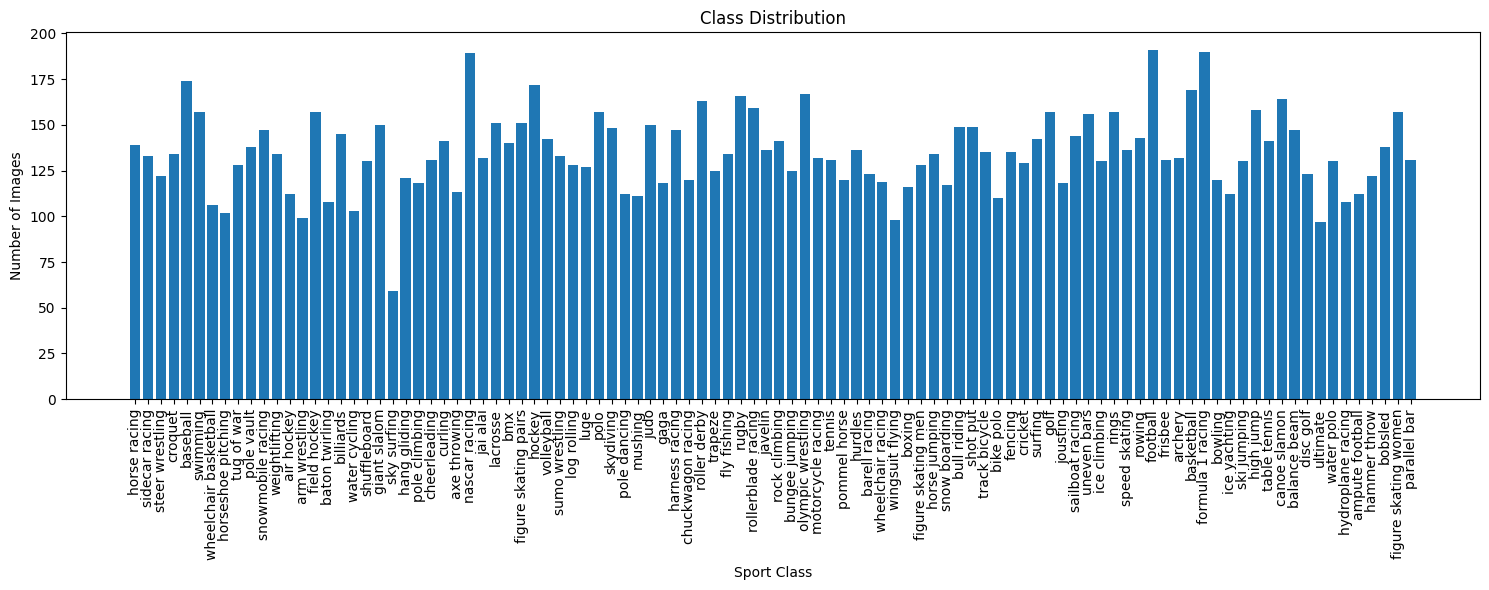

Min images per class: 59
Max images per class: 191
Imbalance ratio: 3.24


In [31]:
#class distribution
import matplotlib.pyplot as plt

# Visualize class distribution
plt.figure(figsize=(15, 6))
plt.bar(sport_type_counts.keys(),sport_type_counts.values())
plt.xticks(rotation=90)
plt.xlabel('Sport Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

# Check for severe imbalance
min_count = min(sport_type_counts.values())
max_count = max(sport_type_counts.values())
print(f"Min images per class: {min_count}")
print(f"Max images per class: {max_count}")
print(f"Imbalance ratio: {max_count/min_count:.2f}")

Sample images

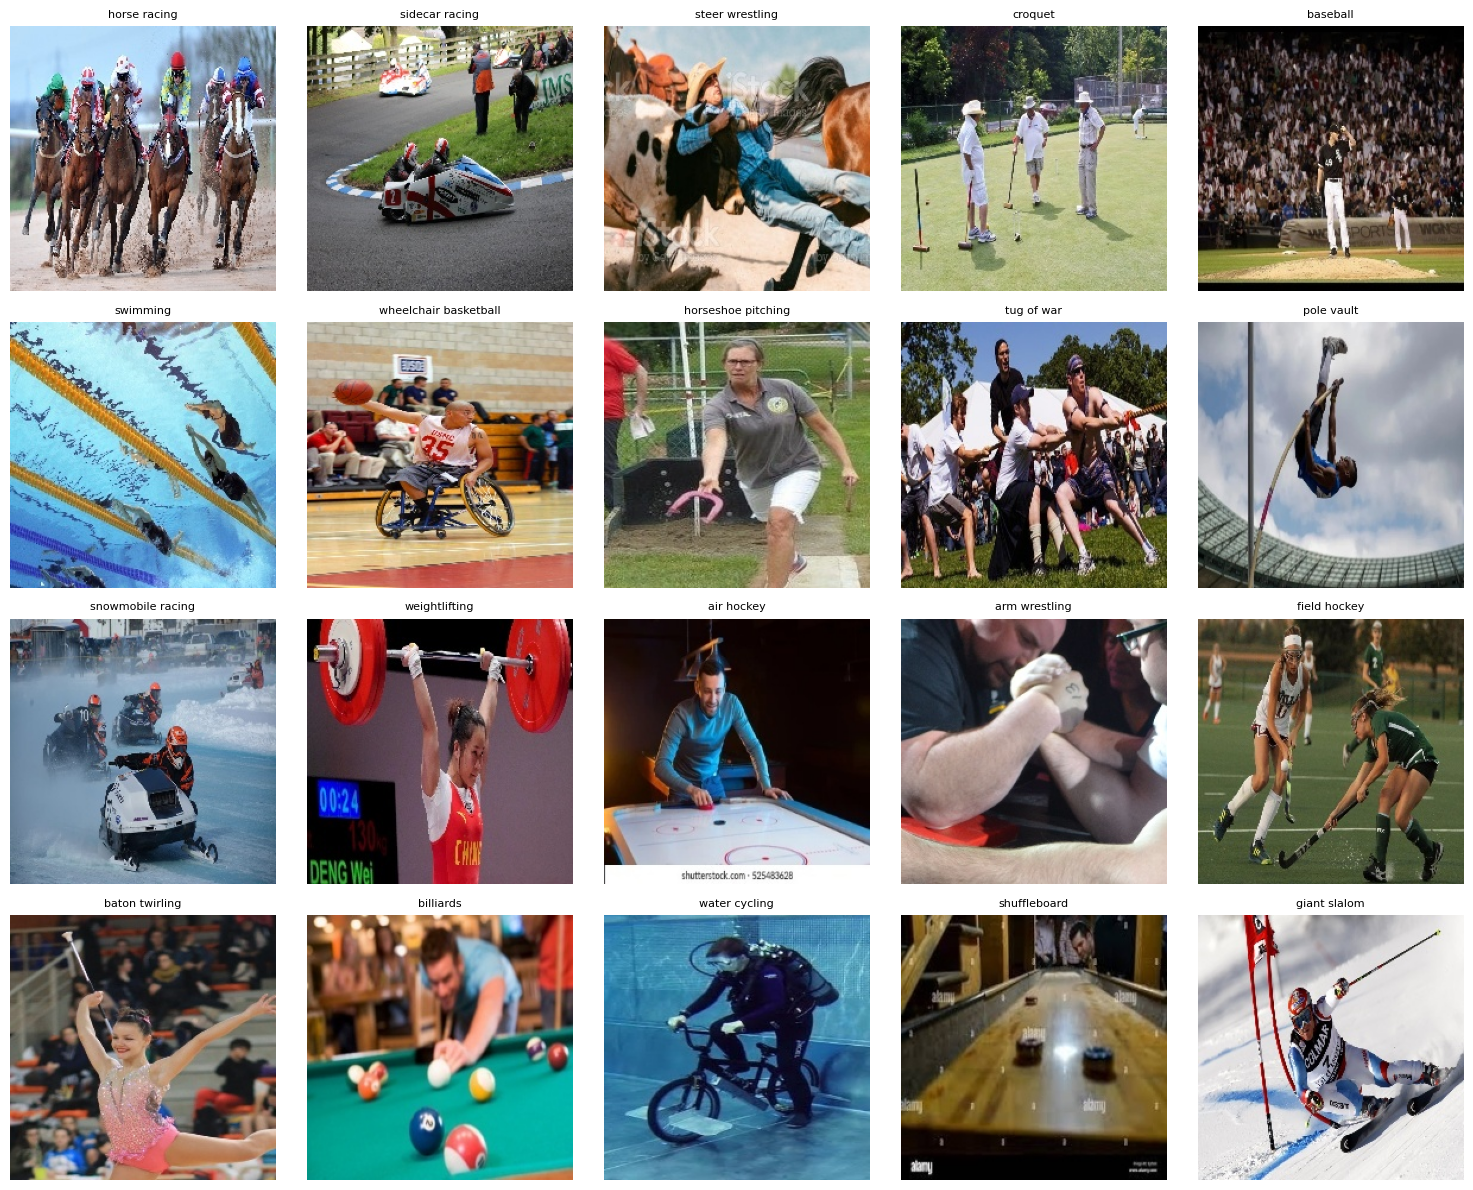

In [32]:
# Display sample images from different classes
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.ravel()

class_paths = [d for d in data_dir.iterdir() if d.is_dir()]

for idx, class_path in enumerate(class_paths[:20]):  # first 20 classes
    img_path = list(class_path.glob('*'))[0]

    img = Image.open(img_path)
    axes[idx].imshow(img)
    axes[idx].set_title(class_path.name, fontsize=8)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [33]:
# Verify all images can be opened
corrupted = []
for class_path in data_dir.iterdir():
    if not class_path.is_dir():
        continue

    for img_path in class_path.glob('*'):
        try:
            img = Image.open(img_path)
            img.verify()  # verify it's actually an image
        except:
            corrupted.append(str(img_path))
            print(f"Deleting: {img_path}")
            img_path.unlink()

print(f"Corrupted images: {len(corrupted)}")
if corrupted:
    print(corrupted)

Deleting: /workspaces/sport-image-classifier/data/train/high jump/159.lnk
Corrupted images: 1
['/workspaces/sport-image-classifier/data/train/high jump/159.lnk']


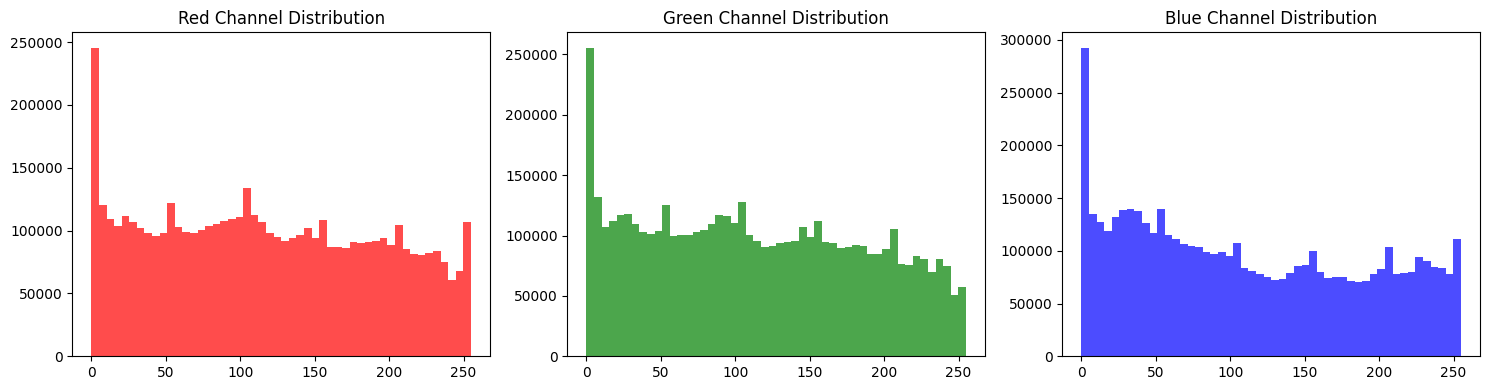

In [35]:
def analyze_colors(data_dir, num_samples=100):
    r_vals, g_vals, b_vals = [], [], []

    for class_path in data_dir.iterdir():
        if not class_path.is_dir():
            continue
        for img_path in list(class_path.glob('*'))[:num_samples//len(list(data_dir.iterdir()))]:
            img = Image.open(img_path).convert('RGB')
            img_array = np.array(img)
            r_vals.extend(img_array[:,:,0].flatten())
            g_vals.extend(img_array[:,:,1].flatten())
            b_vals.extend(img_array[:,:,2].flatten())

    # Plot histograms
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].hist(r_vals, bins=50, color='red', alpha=0.7)
    axes[0].set_title('Red Channel Distribution')
    axes[1].hist(g_vals, bins=50, color='green', alpha=0.7)
    axes[1].set_title('Green Channel Distribution')
    axes[2].hist(b_vals, bins=50, color='blue', alpha=0.7)
    axes[2].set_title('Blue Channel Distribution')
    plt.tight_layout()
    plt.show()

data_dir =   data_folder / "train"
analyze_colors(data_dir)

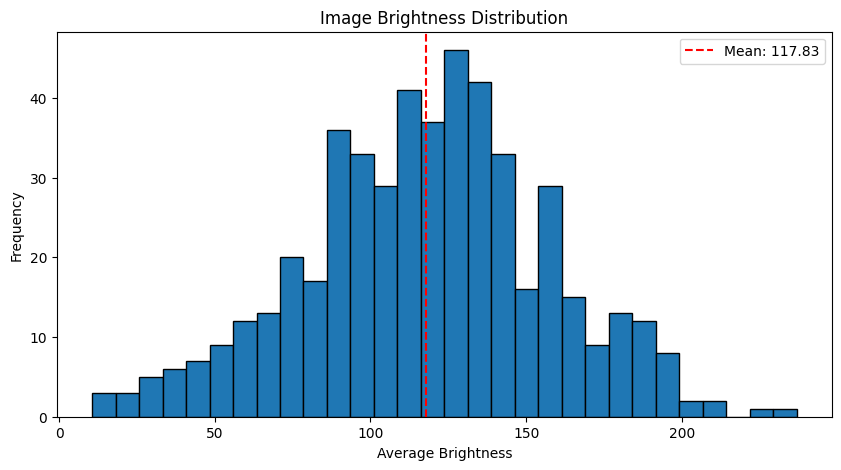

Brightness range: 10.62 - 236.86
Mean brightness: 117.83


In [36]:
# Check brightness levels across dataset
def analyze_brightness(data_dir, num_samples=50):
    brightness_vals = []

    for class_path in list(data_dir.iterdir()):
        if not class_path.is_dir():
            continue
        for img_path in list(class_path.glob('*'))[:num_samples//10]:
            img = Image.open(img_path).convert('L')  # convert to grayscale
            img_array = np.array(img)
            brightness_vals.append(img_array.mean())

    plt.figure(figsize=(10, 5))
    plt.hist(brightness_vals, bins=30, edgecolor='black')
    plt.xlabel('Average Brightness')
    plt.ylabel('Frequency')
    plt.title('Image Brightness Distribution')
    plt.axvline(np.mean(brightness_vals), color='red', linestyle='--',
                label=f'Mean: {np.mean(brightness_vals):.2f}')
    plt.legend()
    plt.show()

    print(f"Brightness range: {min(brightness_vals):.2f} - {max(brightness_vals):.2f}")
    print(f"Mean brightness: {np.mean(brightness_vals):.2f}")

analyze_brightness(data_dir)

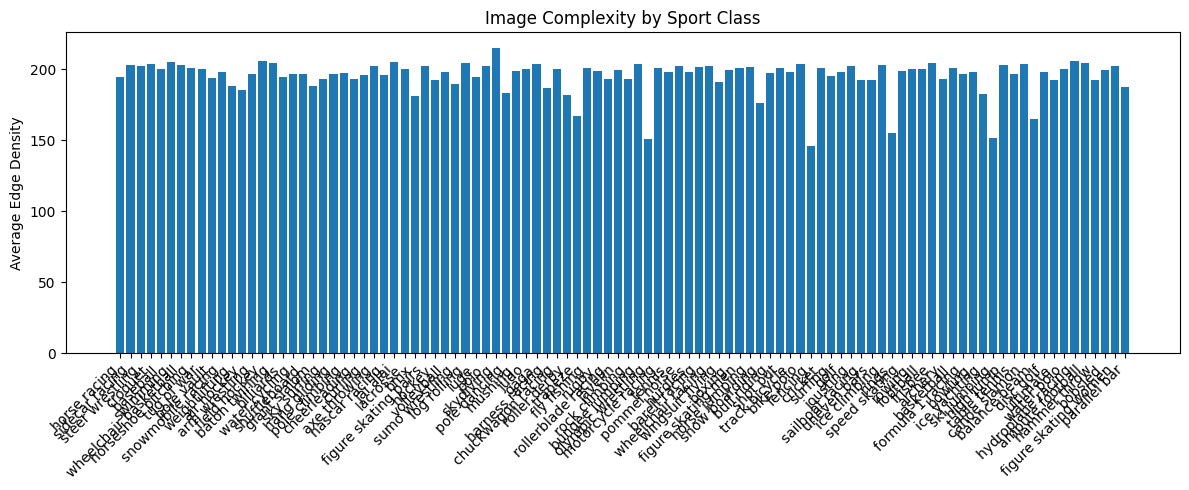

In [37]:
from scipy import ndimage

def analyze_edge_density(data_dir, num_samples=50):
    edge_densities = {}

    for class_path in list(data_dir.iterdir()):
        if not class_path.is_dir():
            continue

        class_edges = []
        for img_path in list(class_path.glob('*'))[:num_samples//10]:
            img = Image.open(img_path).convert('L')
            img_array = np.array(img)

            # Sobel edge detection
            edges_x = ndimage.sobel(img_array, axis=0)
            edges_y = ndimage.sobel(img_array, axis=1)
            edges = np.hypot(edges_x, edges_y)

            edge_density = edges.mean()
            class_edges.append(edge_density)

        edge_densities[class_path.name] = np.mean(class_edges)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.bar(edge_densities.keys(), edge_densities.values())
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Average Edge Density')
    plt.title('Image Complexity by Sport Class')
    plt.tight_layout()
    plt.show()

analyze_edge_density(data_dir)

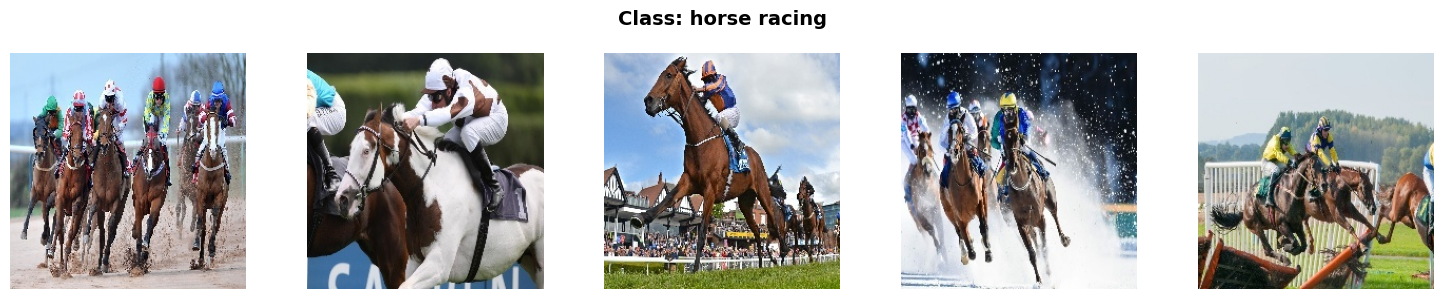

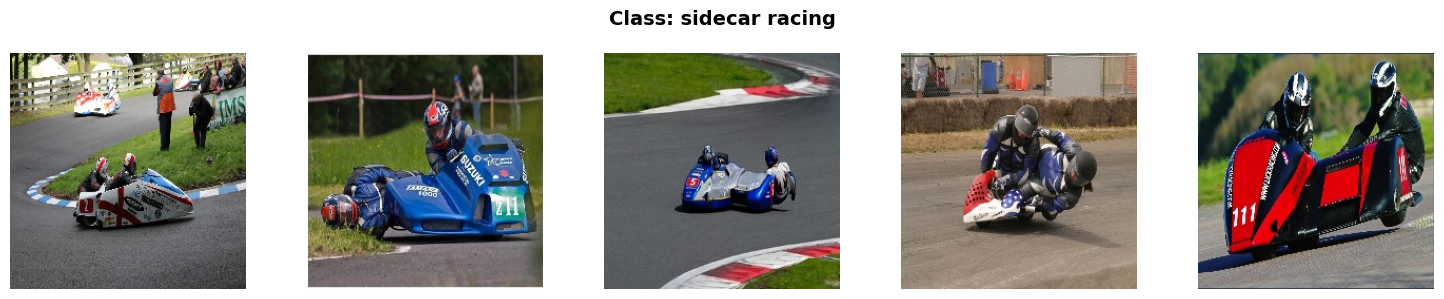

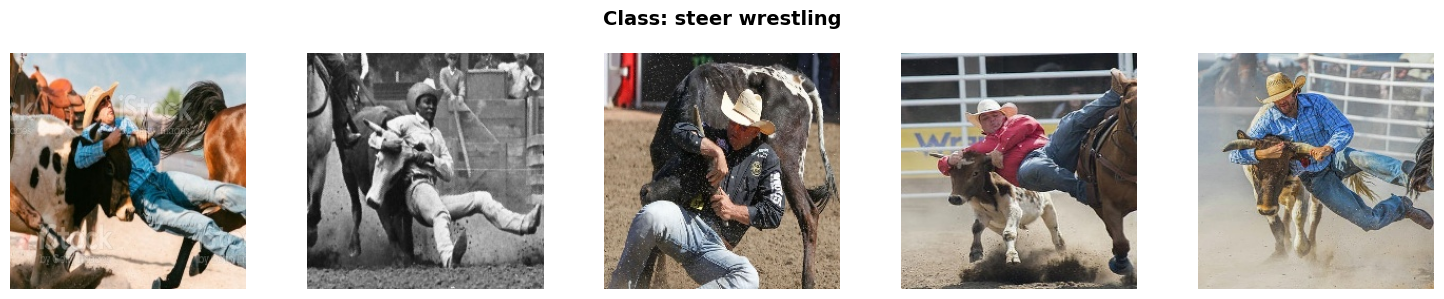

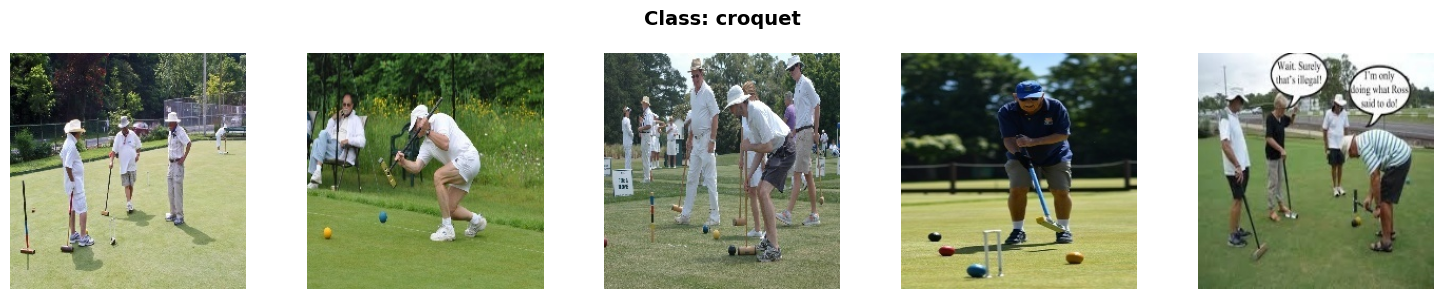

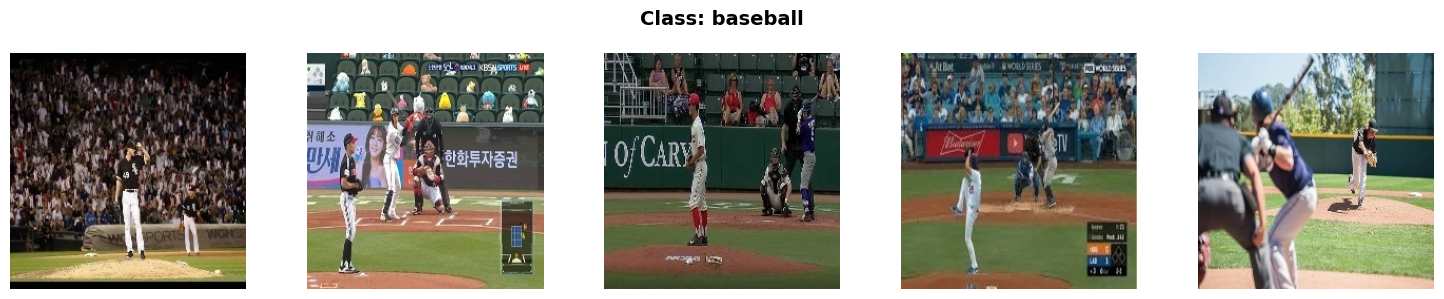

In [38]:
# Check if images have consistent backgrounds or varied backgrounds
def visualize_random_samples_per_class(data_dir, samples_per_class=5):
    class_paths = [d for d in data_dir.iterdir() if d.is_dir()]

    for class_path in class_paths[:5]:  # show first 5 classes
        fig, axes = plt.subplots(1, samples_per_class, figsize=(15, 3))
        fig.suptitle(f'Class: {class_path.name}', fontsize=14, fontweight='bold')

        sample_images = list(class_path.glob('*'))[:samples_per_class]

        for idx, img_path in enumerate(sample_images):
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].axis('off')

        plt.tight_layout()
        plt.show()

visualize_random_samples_per_class(data_dir)

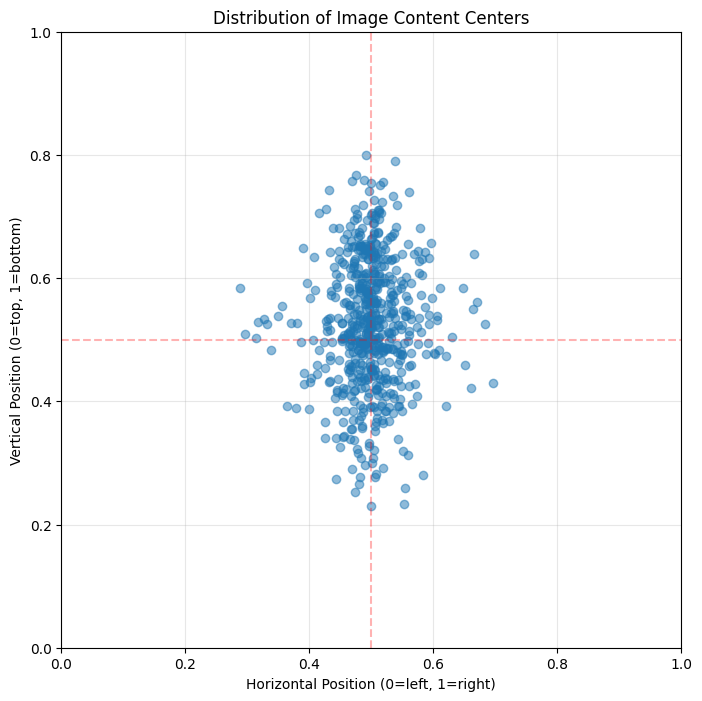

In [40]:
# Check if subjects are centered or vary in position
def analyze_center_mass(data_dir, num_samples=30):
    center_positions = {'x': [], 'y': []}

    for class_path in list(data_dir.iterdir()):
        if not class_path.is_dir():
            continue

        for img_path in list(class_path.glob('*'))[:num_samples//5]:
            img = Image.open(img_path).convert('L')
            img_array = np.array(img)

            # Calculate center of mass
            threshold = img_array.mean()
            binary = img_array > threshold

            if binary.sum() > 0:
                y_coords, x_coords = np.where(binary)
                center_y = y_coords.mean() / img_array.shape[0]
                center_x = x_coords.mean() / img_array.shape[1]

                center_positions['x'].append(center_x)
                center_positions['y'].append(center_y)

    # Plot scatter
    plt.figure(figsize=(8, 8))
    plt.scatter(center_positions['x'], center_positions['y'], alpha=0.5)
    plt.xlabel('Horizontal Position (0=left, 1=right)')
    plt.ylabel('Vertical Position (0=top, 1=bottom)')
    plt.title('Distribution of Image Content Centers')
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.3)
    plt.axvline(0.5, color='red', linestyle='--', alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(alpha=0.3)
    plt.show()

analyze_center_mass(data_dir)

Lots of outdoor sports, aindoor venues, and athletic uniforms are in display

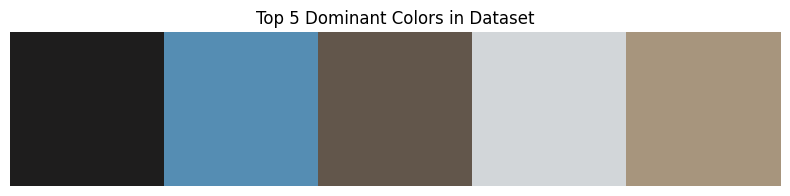

RGB values of dominant colors:
Color 1: RGB(np.int64(30), np.int64(29), np.int64(29))
Color 2: RGB(np.int64(85), np.int64(141), np.int64(179))
Color 3: RGB(np.int64(98), np.int64(86), np.int64(75))
Color 4: RGB(np.int64(210), np.int64(214), np.int64(217))
Color 5: RGB(np.int64(167), np.int64(149), np.int64(125))


In [42]:
from sklearn.cluster import KMeans

def get_dominant_colors(data_dir, n_colors=5, num_samples=20):
    """Find dominant colors across sports"""

    all_pixels = []

    for class_path in list(data_dir.iterdir()):
        if not class_path.is_dir():
            continue
        for img_path in list(class_path.glob('*'))[:num_samples//5]:
            img = Image.open(img_path).convert('RGB').resize((50, 50))
            pixels = np.array(img).reshape(-1, 3)
            all_pixels.append(pixels)

    all_pixels = np.vstack(all_pixels)

    # Sample subset for clustering
    sample_pixels = all_pixels[np.random.choice(len(all_pixels), 10000)]

    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(sample_pixels)

    colors = kmeans.cluster_centers_.astype(int)

    # Visualize
    fig, ax = plt.subplots(1, 1, figsize=(10, 2))
    ax.imshow([colors])
    ax.set_title('Top 5 Dominant Colors in Dataset')
    ax.axis('off')
    plt.show()

    print("RGB values of dominant colors:")
    for i, color in enumerate(colors):
        print(f"Color {i+1}: RGB{tuple(color)}")

get_dominant_colors(data_dir)